# *Prevendo o sucesso de jogos da Steam*
#### Filipe F. Borba  e Guilherme Z. Graicer
#### Insper
#### Machine Learning, Prof. Fábio Ayres


A indústria dos games é um setor de escala gigantesca. Na verdade, já é [maior do que a indústria cinematográfica e da música combinadas](https://www.bbc.com/news/technology-46746593), com um número aproximado de 2.5 bilhões de gamers espalhados pelo mundo. Não apenas isso, mas apenas [o jogo Fornite faturou $2.4 bilhões em 2018](https://www.businessinsider.com/how-much-money-does-fortnite-make-2019-1). 

Com isso, verifica-se a importância de se estudar este mercado e entender suas tendências. Empresas grandes como Microsoft, já fazem sua parte nessa indústria, enquanto outras, como Google, estudam meios para entrar nesse setor ([Google Stadia](https://stadia.google.com/) é um exemplo).

Estudando o cenário, existem  projetos de machine learning que utilizam informações parecidas, mas com aplicações diferentes do nosso projeto. Temos como exemplo o [GameRatingsPredictor](https:///github.com/RobertoFalconi/GameRatingsPredictor), que visa predizer qual a faixa etária permitida para certos jogos usando Random Forest (e outros modelos de comparação). Outros projetos já visam a recomendação de certos jogos baseados nas afinidades do usuário, como é o caso do sistema da própria Steam, o [Interactive Recommender](https://arstechnica.com/gaming/2019/07/steam-turns-to-ai-to-help-users-find-gems-amid-thousands-of-games/).

Assim, gostaríamos de utilizar as técnicas de Machine Learning passadas durante a disciplina para verificar que tipos de jogos são mais atrativos para os jogadores. Para isso, utilizaremos os dados de uma das mais famosas plataformas de jogos, a Steam.

# Importando os dados

Os dados foram retirados da plataforma Kaggle de um dataset (com boas avaliações dadas pelos usuários), o [Steam Store Games](https://www.kaggle.com/nikdavis/steam-store-games?select=steam.csv). Através de uma análise rápida, pudemos verificar que os dados são de boa qualidade e temos diversas features relevantes para o projeto. Os dados deste dataset são relativamente recentes: vão até maio de 2019, o que também é positivo.

Nesta primeira seção, vamos importar as bibliotecas necessárias e carregar os dados.

Obs: Este projeto foi feito utilizando o Google Colab.


In [1]:
# Aqui importamos todas as dependências do projeto

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge

from joblib import dump, load


# Dependências auxiliares
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from collections import Counter
from pprint import pprint

# Permite que os resultados sejam reproduzíveis. Seed de aleatoriedade.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
"""
Caso esteja utilizando o Google Colab, será necessário importar o steam.csv para o workspace.
Caso esteja rodando o notebook localmente, basta copiar o steam.csv para a mesma pasta do notebook.

Aqui, fazemos a leitura do CSV num dataframe Pandas.
"""
FILE = 'steam.csv'
df = pd.read_csv(FILE)

# Explorando o Dataset

Nesta seção, estamos tentando entender melhor os dados do dataset de jogos da steam. Buscamos ver a correlação das variáveis, dados faltando, outliers e outras informações importantes acerca do dataset.

Primeiro, procuramos entender o tamanho do dataset, os tipos dos dados e o conteúdo de algumas linhas.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [4]:
df.head(n=5)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [5]:
df.describe()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.012300e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,5.990700e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,7.987600e+05,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.069460e+06,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


In [6]:
df.corr()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
appid,1.000000,-0.116878,-0.087740,0.040510,-0.070888,-0.052198,-0.070236,-0.048308,-0.152112
english,-0.116878,1.000000,0.002860,0.014121,0.006001,0.005705,0.000338,-0.003416,0.007716
required_age,-0.087740,0.002860,1.000000,-0.005459,0.060418,0.057599,0.034423,0.014748,0.120358
achievements,0.040510,0.014121,-0.005459,1.000000,0.006058,0.003578,0.014175,0.009957,-0.007996
positive_ratings,-0.070888,0.006001,0.060418,0.006058,1.000000,0.762804,0.157898,0.035776,0.036110
negative_ratings,-0.052198,0.005705,0.057599,0.003578,0.762804,1.000000,0.161140,0.047887,0.051259
average_playtime,-0.070236,0.000338,0.034423,0.014175,0.157898,0.161140,1.000000,0.914900,0.049242
median_playtime,-0.048308,-0.003416,0.014748,0.009957,0.035776,0.047887,0.914900,1.000000,0.036610
price,-0.152112,0.007716,0.120358,-0.007996,0.036110,0.051259,0.049242,0.036610,1.000000


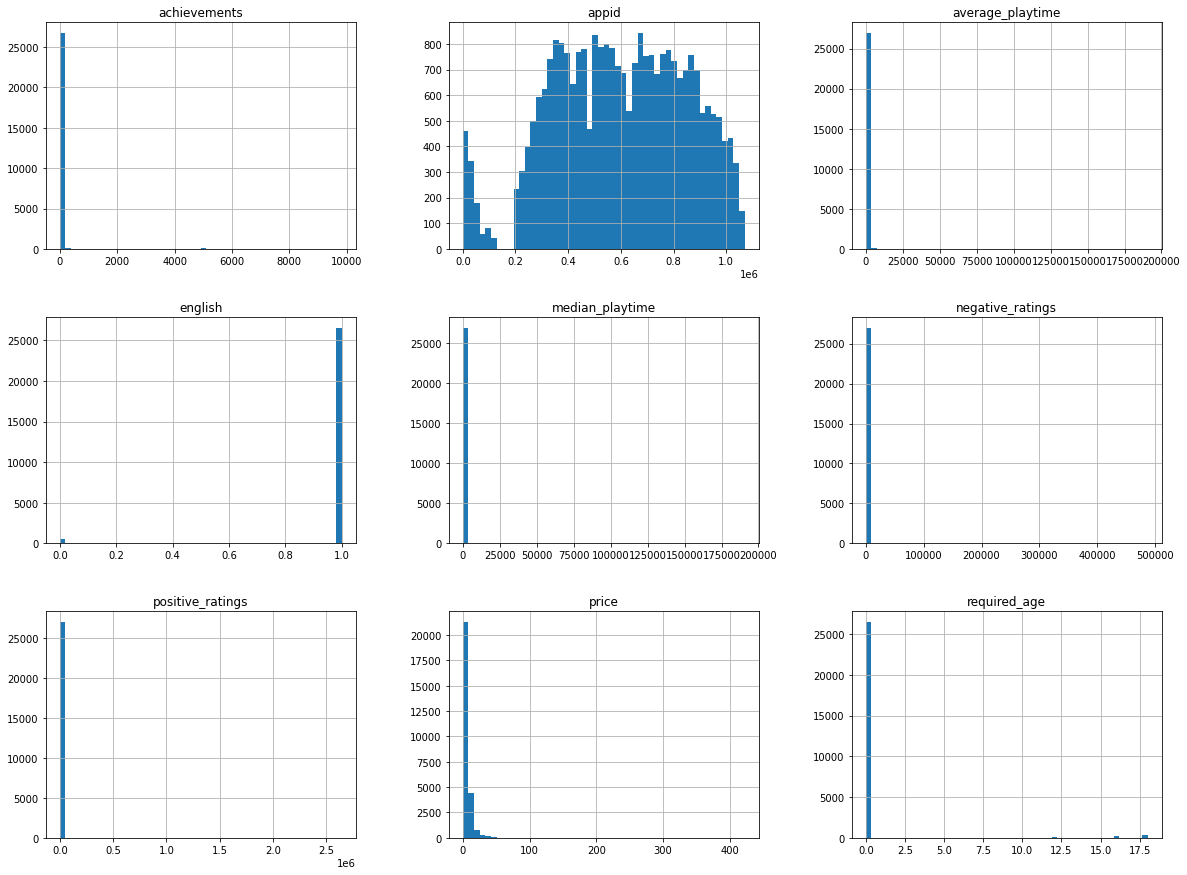

In [7]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Numa análise preliminar, podemos verificar que o dataset conta com algumas variáveis que precisam de tratamento e outras inúteis. O interessante aqui é que as variáveis são bastante concentradas em alguns valores (`price`, por exemplo) e outras são categóricas apesar de seu conteúdo serem números (`english`, por exemplo). Além disso, os histogramas não mostram muitas informações relevantes, pois existem outliers (poucos números com valores muito altos).

Na célula a seguir, é possível verificar a similaridade das colunas `categories, genres e steamspy_tags`. As três procuram definir melhor o tipo de jogo e serão explicadas mais para frente quando formos preparar o dataset para uso. Precisamos transformar essas características em features para o nosso modelo.

Observando as colunas `developer` e `publisher`, constatamos que podemos ter diversos Developers e Publishers diferentes para um mesmo jogo, então também precisamos transformá-los em features para o nosso modelo. Essa operação será explicada mais adiante.

A coluna `platforms` tem apenas uma combinação de `windows`, `mac` ou `linux` como possíveis valores.

Todas as *features*  citadas aqui são categóricas e serão terão que passar por uma espécie de *encoder* para entrar no modelo. Isso transformará, cada categoria delas em uma *feature* própria valendo 0 ou 1 de acordo com sua presença no jogo.

In [8]:
pd.concat([df.iloc[23:26], df.iloc[149:151]])

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
23,620,Portal 2,2011-04-18,1,Valve,Valve,windows;mac;linux,0,Single-player;Co-op;Steam Achievements;Full co...,Action;Adventure,Puzzle;Co-op;First-Person,51,138220,1891,1102,520,10000000-20000000,7.19
24,630,Alien Swarm,2010-07-19,1,Valve,Valve,windows,0,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Free to Play;Co-op;Action,66,17435,941,371,83,2000000-5000000,0.00
25,730,Counter-Strike: Global Offensive,2012-08-21,1,Valve;Hidden Path Entertainment,Valve,windows;mac;linux,0,Multi-player;Steam Achievements;Full controlle...,Action;Free to Play,FPS;Multiplayer;Shooter,167,2644404,402313,22494,6502,50000000-100000000,0.00
149,6020,STAR WARS™ Jedi Knight - Jedi Academy™,2009-09-16,1,Raven Software;Aspyr (Mac),LucasArts;Aspyr (Mac);Lucasfilm;Disney Interac...,windows;mac,0,Single-player;Online Multi-Player;Local Multi-...,Action,Star Wars;Action;Sci-fi,0,5684,330,1254,174,1000000-2000000,7.19
150,6030,STAR WARS™ Jedi Knight II - Jedi Outcast™,2009-09-16,1,Raven Software;Aspyr (Mac),LucasArts;Aspyr (Mac);Lucasfilm;Disney Interac...,windows;mac,0,Single-player;Online Multi-Player;Local Multi-...,Action,Star Wars;Action;Classic,0,2020,219,127,180,1000000-2000000,7.19


# Preparando o Dataset

Após analisar o dataset sem realizar modificações, vamos tratá-lo, adicionando algumas colunas importantes para o treinamento e removendo outras que são irrelevantes. A primeira que vamos adicionar é a `positive_rate` que representa a porcentagem de avaliações positivas nos jogos. Utilizaremos essa métrica como variável dependente do nosso projeto, pois queremos descobrir como ela interage com as outras e prever ela de acordo com as outras. Essa métrica é comum na loja da Steam para indicar jogos bem avaliados pelos jogadores.

<figure>
  <center>
  <a href="https://i.imgur.com/WcyTDHw.png?1">
  <img src="https://i.imgur.com/WcyTDHw.png?1" alt="CSGO Positive Reviews Jun 09 - 2020" height="200" />
  </a>
  <figcaption>Página da loja da Steam com as avaliações do jogo Counter-Strike: Global Offensive - Clique para aumentar</figcaption>
  </center>
</figure>

Além disso, como verificado, as colunas `categories, genres e steamspy_tags` são similares. A coluna `categories` indica filtros utilizados pela loja da Steam para agrupar certos jogos, com categorias específicas e genéricas ao mesmo tempo, muitas vezes tendo valores irrelevantes ou valores que não são comuns a todos os dados. A coluna `genres` possui uma definição do tipo do jogo mais clara, porém mais generalista (ex: Ação). Por fim, a coluna `steamspy_tags` contém rotulagens (tags) feitas por usuários no site SteamSpy. Os usuários votam nas tags que melhor representam cada jogo, assim, quanto mais votos, melhor associada a tag é com o jogo. Com isso, podemos apurar melhor o tipo de jogo, contendo informações comuns a todos os jogos e abrangentes o suficiente para definir melhor tipo. Assim, podemos descartar `categories` e manter as outras duas colunas para nosso projeto.




In [9]:
df.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price'],
      dtype='object')

In [10]:
df['positive_rate'] = df['positive_ratings'] / (df['positive_ratings']+df['negative_ratings'])
df['positive_rate'].head(n=5)

0    0.973888
1    0.839787
2    0.895648
3    0.826623
4    0.947996
Name: positive_rate, dtype: float64

In [11]:
# platforms

# df_platforms = df['platforms'].str.get_dummies(';')
# df_platforms = df_platforms.add_prefix('platform_')
# df_platforms.head(n=1)

In [12]:
# steamspy_tags

# df_steamspy_tags = df['steamspy_tags'].str.get_dummies(';')
# df_steamspy_tags = df_steamspy_tags.add_prefix('tags_')
# df_steamspy_tags.head(n=1)

In [13]:
# genres

# df_genres = df['genres'].str.get_dummies(';')
# df_genres = df_genres.add_prefix('genres_')
# df_genres.head(n=1)

In [14]:
# owners

# df_owners = df['owners'].str.get_dummies(';')
# df_owners = df_owners.add_prefix('owners_')
# df_owners.head(n=1)

### `publisher & developer`

Existe um problema aqui, a quantidade de publishers e developers diferentes é tão grande que inviabiliza a criação de uma coluna para cada.
Ademais, a maioria deles só estão ligados a um jogo. 
Para resolver isso, os nomes dos publishers e developers que tem somente um jogo foram substituidos por "Outros".

Com isso, utilizamos a função get_dummies do pandas para transformar essas duas colunas em diversas colunas de features. Cada publisher & developer individualmente se torna uma nova coluna com valor 0 ou 1 para indicar sua presença no jogo.

Isso torna-se uma limitação do nosso modelo, mas foi a maneira achada para usar essa variavel categórica, visto que aumentamos o número de features drasticamente.

In [15]:
pub_counts = Counter([v.strip() for x in df['publisher'] for v in x.strip().split(';')])
pub_list = sorted(((v, k) for k, v in pub_counts.items()), reverse=True)

In [16]:
dev_counts = Counter([v.strip() for x in df['developer'] for v in x.strip().split(';')])
dev_list = sorted(((v, k) for k, v in dev_counts.items()), reverse=True)

In [17]:
one_game_pubs = []
one_game_devs = []
for i in range(len(pub_list)):
  if pub_list[i][0] == 1:
    one_game_pubs.append(pub_list[i][1])

for i in range(len(dev_list)):
  if dev_list[i][0] == 1:
    one_game_devs.append(dev_list[i][1])
                         
print(f"Número total de publishers diferentes: {len(pub_list)}")
print(f"Quantidade deles que estão ligados a somente um jogo: {len(one_game_pubs)}")
print()

print(f"Número total de developers diferentes: {len(dev_list)}")
print(f"Quantidade deles que estão ligados a somente um jogo: {len(one_game_devs)}")

Número total de publishers diferentes: 14238
Quantidade deles que estão ligados a somente um jogo: 10840

Número total de developers diferentes: 17952
Quantidade deles que estão ligados a somente um jogo: 13671


In [18]:
def replace_one_game_pubs(s):
  """
  Função que recebe a string de publishers e devolve mascarando os que tem somente um jogo,
  chamando-os de 'outros'

  args: string da célula da coluna Publishers
  output: string 'mascarada'
  """
  
  game_pub_list = [v.strip() for v in s.strip().split(';')]
  for i, pub in enumerate(game_pub_list):
    if pub in one_game_pubs:
      game_pub_list[i] = 'others'
  
  game_pub_set = set(game_pub_list)

  new_s = ""

  for e in game_pub_set:
    new_s += e
    new_s += ";"
  new_s = new_s[:-1]

  return new_s

def replace_one_game_devs(s):
  """
  Função que recebe a string de developers e devolve mascarando os que tem somente um jogo,
  chamando-os de 'outros'

  args: string da célula da coluna Developer
  output: string 'mascarada'
  """
  game_dev_list = [v.strip() for v in s.strip().split(';')]
  for i, dev in enumerate(game_dev_list):
    if dev in one_game_devs:
      game_dev_list[i] = 'others'
  
  game_dev_set = set(game_dev_list)

  new_s = ""

  for e in game_dev_set:
    new_s += e
    new_s += ";"
  new_s = new_s[:-1]

  return new_s

In [19]:
# Aplicando a função acima a todas as colunas do dataframe
df['publisher'] = df['publisher'].apply(lambda x: replace_one_game_pubs(x))

# Aplicando a função acima a todas as colunas do dataframe
df['developer'] = df['developer'].apply(lambda x: replace_one_game_devs(x))

In [20]:
# Agora sim, cria-se um dataframe com uma coluna por publisher
# df_publisher = df['publisher'].str.get_dummies(';')
# df_publisher = df_publisher.add_prefix('pub_')
# df_publisher.head()

# df_developer = df['developer'].str.get_dummies(';')
# df_developer = df_developer.add_prefix('dev_')
# df_developer.head()

Com todos os dataframes de variáveis tratados, basta concatená-los ao dataframe original, removendo as colunas dessas categorias. Além disso, foram removidas as outras categorias irrelevantes para o treinamento:
- `positive_ratings & negative_ratings`: já foram usados para estabelecer o `positive_rate` 
- `appid`: apenas um identificador, é irrelevante.
- `name` e `release_date`: irrelevantes para o treinamento do modelo
- `platform, publishers, developers, steamspy_tags, owners, required_age`: todas transformadas com o get_dummies, sem necessidade de mantê-los.

Uma observação importante é que para cada dummy das categorias utilizadas, adicionamos um prefixo (referente a *feature* original de onde pertencia essa categoria) para facilitar a identificação no momento da análise.

### Dataset tratado

In [21]:
# df = pd.concat([df, df_platforms, df_steamspy_tags, df_genres, df_publisher,df_developer, df_owners], axis=1).drop(columns=['name', 'release_date', 'appid', 'developer', 'publisher', 'platforms', 'categories', 'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'owners'])
# tudo que foi comentado nas células acima está na linha abaixo, para evitar a criação de vários DataFrames e o consumo exessivo de RAM

In [22]:
df = pd.concat([df, df['platforms'].str.get_dummies(';').add_prefix('platform_'), df['steamspy_tags'].str.get_dummies(';').add_prefix('tags_'), df['genres'].str.get_dummies(';').add_prefix('genres_'), df['publisher'].str.get_dummies(';').add_prefix('pub_'), df['developer'].str.get_dummies(';').add_prefix('dev_'), df['owners'].str.get_dummies(';').add_prefix('owners_'), df['required_age'].apply(str).str.get_dummies(';').add_prefix('age_')], axis=1).drop(columns=['name', 'release_date', 'appid', 'developer', 'publisher', 'platforms', 'categories', 'genres', 'steamspy_tags', 'positive_ratings', 'negative_ratings', 'owners', 'required_age'])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 8076 entries, english to age_7
dtypes: float64(2), int64(8074)
memory usage: 1.6 GB


In [24]:
df.to_csv('worked_df.csv')

In [25]:
df = pd.read_csv('worked_df.csv', index_col=[0])

In [26]:
df.head(5)

,english,achievements,average_playtime,median_playtime,price,positive_rate,platform_linux,platform_mac,platform_windows,tags_1980s,tags_1990's,tags_2.5D,tags_2D,tags_2D Fighter,tags_360 Video,tags_3D,tags_3D Platformer,tags_3D Vision,tags_4 Player Local,tags_4X,tags_6DOF,tags_Abstract,tags_Action,tags_Action RPG,tags_Action-Adventure,tags_Adventure,tags_Agriculture,tags_Aliens,tags_Alternate History,tags_America,tags_Animation & Modeling,tags_Anime,tags_Arcade,tags_Arena Shooter,tags_Assassin,tags_Atmospheric,tags_Audio Production,tags_BMX,tags_Base-Building,tags_Baseball,...,dev_吃了就睡工作室,dev_哈视奇科技,dev_大好网,dev_威震天科技,dev_小戴的奴隶们,dev_木子工坊,dev_朵游社,dev_梵天游戏,dev_橘喵喵,dev_橘子班,dev_橙光游戏,dev_灰烬天国,dev_热泉 RedSpring,dev_甲山林娛樂股份有限公司,dev_疯王子,dev_绚丽奈落,dev_自由愉悦小黄猫(Free pleasure little yellow cat),dev_致意,dev_迷茫的菜鸟,dev_阿达游戏,dev_黄昏フロンティア,owners_0-20000,owners_100000-200000,owners_1000000-2000000,owners_10000000-20000000,owners_100000000-200000000,owners_20000-50000,owners_200000-500000,owners_2000000-5000000,owners_20000000-50000000,owners_50000-100000,owners_500000-1000000,owners_5000000-10000000,owners_50000000-100000000,age_0,age_12,age_16,age_18,age_3,age_7
0,1,0,17612,317,7.19,0.973888,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,0,277,62,3.99,0.839787,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,187,34,3.99,0.895648,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,1,0,258,184,3.99,0.826623,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,1,0,624,415,3.99,0.947996,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


Agora temos um dataset totalmente tratado, com as variáveis categóricas incorporadas e variáveis inúteis removidas. Está na hora de dividir os dados em treinamento e testes.





# Dividindo os dados em conjunto de treinamento e de testes (estratificado)
Para dividir os dados em treinamento e teste, precisamos fazer uma divisão estratificada deles. Ou seja, a proporção da variável dependente entre os sets de treinamento e teste devem ser parecidas.

Para garantir isso, foi feita uma coluna nova no dataframe (rate_cat) que divide os jogos em 5 categorias, uma para cada quinto entre 0 e 100%. A divisão estratificada foi feita com base nessa nova categoria.

In [27]:
# Constroi uma coluna nova com categorias de positive_negative_rate fictícias.
df['rate_cat'] = np.round(df['positive_rate']*100 / 20)
# housing['rate_cat'].where(housing['rate_cat'] < 5, 5.0, inplace=True)

In [28]:
# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(df, df["rate_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [29]:
strat_train_set['rate_cat'].value_counts() / len(strat_train_set)

4.0    0.366851
5.0    0.235365
3.0    0.207525
2.0    0.130286
1.0    0.033841
0.0    0.026131
Name: rate_cat, dtype: float64

In [30]:
strat_test_set['rate_cat'].value_counts() / len(strat_test_set)

4.0    0.366759
5.0    0.235272
3.0    0.207572
2.0    0.130379
1.0    0.033795
0.0    0.026223
Name: rate_cat, dtype: float64

In [31]:
# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['rate_cat'], axis=1, inplace=True)
strat_test_set.drop(['rate_cat'], axis=1, inplace=True)

In [32]:
strat_test_set

,english,achievements,average_playtime,median_playtime,price,positive_rate,platform_linux,platform_mac,platform_windows,tags_1980s,tags_1990's,tags_2.5D,tags_2D,tags_2D Fighter,tags_360 Video,tags_3D,tags_3D Platformer,tags_3D Vision,tags_4 Player Local,tags_4X,tags_6DOF,tags_Abstract,tags_Action,tags_Action RPG,tags_Action-Adventure,tags_Adventure,tags_Agriculture,tags_Aliens,tags_Alternate History,tags_America,tags_Animation & Modeling,tags_Anime,tags_Arcade,tags_Arena Shooter,tags_Assassin,tags_Atmospheric,tags_Audio Production,tags_BMX,tags_Base-Building,tags_Baseball,...,dev_吃了就睡工作室,dev_哈视奇科技,dev_大好网,dev_威震天科技,dev_小戴的奴隶们,dev_木子工坊,dev_朵游社,dev_梵天游戏,dev_橘喵喵,dev_橘子班,dev_橙光游戏,dev_灰烬天国,dev_热泉 RedSpring,dev_甲山林娛樂股份有限公司,dev_疯王子,dev_绚丽奈落,dev_自由愉悦小黄猫(Free pleasure little yellow cat),dev_致意,dev_迷茫的菜鸟,dev_阿达游戏,dev_黄昏フロンティア,owners_0-20000,owners_100000-200000,owners_1000000-2000000,owners_10000000-20000000,owners_100000000-200000000,owners_20000-50000,owners_200000-500000,owners_2000000-5000000,owners_20000000-50000000,owners_50000-100000,owners_500000-1000000,owners_5000000-10000000,owners_50000000-100000000,age_0,age_12,age_16,age_18,age_3,age_7
4787,1,18,0,0,5.59,0.904762,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15124,1,0,0,0,0.79,0.500000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9248,1,35,309,324,44.99,0.564729,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
15876,1,15,0,0,3.99,1.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4873,1,50,245,276,14.99,0.884898,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12303,1,15,0,0,6.99,0.816754,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
13995,1,12,0,0,1.99,0.909091,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16036,1,81,45,45,9.29,0.797382,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1256,1,12,188,146,9.99,0.862047,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Separando X e y
Após separar os sets de treinamento e teste, queremos dividir as labels (y) das features (X).

In [33]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
steam = strat_train_set.drop(["positive_rate"], axis=1)

# Variável dependente, também chamada de label.
steam_labels = strat_train_set["positive_rate"].copy()

In [34]:
steam_labels #são os positive_rates

14854    1.000000
9552     0.898876
3991     0.512821
12574    0.416667
4837     0.675000
           ...   
2101     0.513174
4007     0.900662
12592    0.875000
14847    0.608696
18645    0.444444
Name: positive_rate, Length: 21660, dtype: float64

# Definindo modelos


Neste projeto, utilizaremos uma série de modelos para realizar as predições das porcentagens de avaliações positivas, a fim de entender quais modelos mais se adequam ao problema e fazer análises mais profundas. Para isso, é feita uma validação onde compara-se o RMSE desses modelos, afim de achar o que gera o menor valor.

Obs.: Uma limitação do nosso projeto é que não conseguimos fazer uma validação cruzada nem um ajuste de hiperparâmetros, pois o `cross_val` e o `GridSearchCV` não rodam por falta de RAM. No lugar disso foi feita uma validação simples e um ajuste manual de um parâmetro (o da regularização).

### Decision Trees

Um dos algoritmos propostos será o de Decision Trees: um algoritmo de Machine Learning bastante versátil, que pode realizar tanto tarefas de classificação quanto regressão, além de tarefas com outputs múltiplos, com datasets bastante complexos. As Decision Trees também são componentes fundamentais das Random Forests, que estão entre os algoritmos de Machine Learning mais poderosos atualmente.

Mas como esses algoritmos funcionam? As Decision Trees utilizam o chamado CART (ou Classification And Regression Tree) para realizar o treinamento. A ideia dele é basicamente dividir o set de treinamento usando uma feature e um threshold para tentar produzir subsets com maior pureza (minimizando, assim, o erro). Com isso, o algoritmo cria bifurcações de **decisões** para diminuir os possíveis resultados. Essa ideia fica mais intuitiva quando observamos a imagem a seguir:

<figure>
  <center>
  <a href="https://i.imgur.com/DCCPl8Y.png">
  <img src="https://i.imgur.com/DCCPl8Y.png" alt="Exemplo de Decision Tree usando o famoso Iris dataset" height="300" />
  </a>
  <figcaption> Exemplo de Decision Tree usando o famoso Iris dataset - Clique para aumentar</figcaption>
  </center>
</figure>

Uma das grandes vantagens é que não é necessário escalar as features para a Decision Tree, pois ela não é afetada por isso. Isso acontece, pois ela utiliza somente uma feature por tomada de decisão, nunca comparando mais de uma. Ela vai utilizar os valores da própria feature para compor seus thresholds nos nós. Se ela está tratando com 1000 ou 1, não fará diferença para esse threshould. Assim, podemos dizer que as Decision Trees são modelos não-paramétricos.

Um modelo paramétrico, como por exemplo um modelo linear, tem um número pré-determinado de parâmetros, então seus graus de liberdade são limitados, reduzindo o risco de overfitting, mas aumentando o risco de underfitting. Já um modelo não-paramétrico, como o Decision Tree, não possui esse número pré-determinado, mas sim ele tentará se adaptar aos dados, criando uma estrutura própria que o ajude a se manter próximo aos dados. O problema disso é que o risco de overfitting é muito alto, mas há ganhos de simplicidade de treinamento, entre outros. Para diminuir esse risco, é necessário ajustar os hiperparâmetros do modelo, a fim de evitar overfitting.


### Random Forest

Agora, suponha que você pergunte algo complexo para milhares de pessoas aleatórias e agregue suas respostas. Em muitos casos, você vai observar que essa resposta agregada é melhor do que a resposta de um especialista. Isto é chamado de *sabedoria das multidões* (ou *wisdom of the crowds*). 

De forma similar, se você agregar as predições de um grupo de modelos, você frequentemente sairá com melhores predições do que com apenas um ótimo modelo. Um grupo de preditores é chamado de *ensemble* (ou conjunto); assim, essa técnica é chamada de Ensemble Learning.

Este é o caso da famosa Random Forest que discutimos mais cedo. Esse algoritmo nada mais é do que um conjunto de Decision Trees que foram treinadas em subsets aleatórios do nosso set de treinamento. Para fazer as predições, basta obter as predições de todas as árvores individualmente e agregá-las para fazer uma média, no caso de regressão, ou a classe mais votada, no caso de classificação.

<figure>
  <center>
  <a href="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png">
  <img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png" alt="Estrutura da Random Forest" height="300" />
  </a>
  <figcaption> Estrutura da Random Forest - Clique para aumentar</figcaption>
  </center>
</figure>

Apesar da sua simplicidade, a Random Forest é um dos algoritmos mais poderosos de Machine Learning disponíveis atualmente.

### Modelos Lineares Regularizados

Como visto na definição das Decision Trees, elas possuem um alto risco de *overfitting*, ou seja, ele pode se ajustar tão bem aos dados de treinamento que ajusta-se ao seu ruído, tornando o erro de validação e teste muito mais alto. Para evitar isso, podemos ajustar seus hiperparâmetros. 

Contudo, precisamos também variar os modelos para medir a qualidade. Para isso, utilizaremos os modelos lineares com e sem regularizações.

Uma boa maneira de se reduzir o *overfitting* nesses modelos é regularizando-os. Um exemplo de regularização seria restringi-lo: quanto menos graus de liberdade o modelo tiver, mais dificíl de acontecer *overfit* sobre os dados. Para um modelo linear, a regularização tipicamente é realizada através da restrição dos pesos do modelo.
Veremos então as regressões Ridge, Lasso e Elastic Net, que são três implementações diferentes de restrição de pesos.

#### Ridge Regression

A regressão Ridge é uma versão regularizada da regressão linear com um *termo de regularização* adicionado à função de custo. Esse termo é dado por 

$J(\theta) = MSE(\theta) +  {\alpha} {\sum_{i=1}^{n}} = {{\theta}^2 _i}$

Com $\theta$ sendo cada amostra do dataset.

Isso força o algoritmo de aprendizado não apenas a se adequar aos dados, mas para manter os pesos do modelo o mais baixos possível. É importante notar que o termo de regularização só deve ser adicionado à função de custo no treinamento, avaliando a métrica de performance sem regularização no momento do teste.

O hiperparâmetro ${\alpha}$ é responsável por controlar o quão regularizado será o modelo:


*   Se ${\alpha} = 0$, não há regularização.
*   Se ${\alpha}$ for muito alto, então todos os pesos ficam perto de zero e o resultado é uma linha passando pela média dos dados.

#### Lasso Regression

A regressão Lasso é uma outra forma de regularizar a regressão Linear. Assim como a Ridge, adicionamos um termo de regularização à função de custo do modelo. Este termo é dado por:

 $J(\theta) = MSE(\theta) +{\alpha} {\sum_{i=1}^{n}} = {|{\theta}_i|}$.

Uma característica importante da regressão Lasso é que ela tende a eliminar completamente os pesos das *features menos importantes*, até mesmo zerando-as. Assim, é possível usar esse tipo de técnica para realizar a seleção de features automaticamente, retornando um modelo esparso (ou seja, com poucos pesos de features não-nulos).


#### Elastic Net

Já o Elastic Net é um nível intermediário entre a regressão Ridge e Lasso. O termo de regularização nesse caso é uma simples mistura dos termos das outras duas regressões, com uma variável $r$ que permite controlar a razão de mescla desses termos.


*   Quando $r = 0$, o Elastic Net é equivalente à Ridge Regression.
*   Quando $r = 1$, o Elastic Net é equivalente à Lasso Regression.

Esse termo então fica com a fórmula:

$J(\theta) = MSE(\theta) +{{r \alpha \sum_{i=1}^n | \theta _i |} + {\frac{1-r}{2}}\alpha \sum_{i=1}^n \theta^2 _i}$

Geralmente é bom ter pelo menos um pouco de regularização no modelo, então prefere-se evitar a regressão Linear simples. Mas como escolher entre todas essas opções?

A regressão Ridge é um bom padrão, mas a Lasso e Elastic Net são mais recomendadas, pois elas tendem a reduzir o peso das features inúteis a zero, como discutido anteriormente. Contudo, a Elastic Net é preferida ao invés da Lasso, pois essa segunda pode ter resultados inesperados se o número de features for maior que o tamanho do set de treino ou quando várias features são fortemente correlacionadas.

### Logito

Algo importante de se notar é a implementação do logito na variável `positive_rate`. Como essa variável dependente é uma porcentagem (ela está necessariamente no intervalo de 0 a 1) para os regressores lineares funcionarem bem foi preciso aplicar nela uma função chamada logito. Essa função transforma o intervalo de 0 a 1 em um de menos infinito a mais infinito. Matematicamente o logito é definido como:

$$
f(x) = log(\frac{x}{1 - x})
$$

Tivemos de aplicar essa função, pois a regressão linear naturalmente nunca seria capaz de se adequar a curva da nossa variável, que se assemelha a uma função logística.

<figure>
  <center>
  <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" alt="Função logística" height="300" />
  </a>
  <figcaption> Função logística, imitando a curva do positive_rate - Clique para aumentar</figcaption>
  </center>
</figure>

Então, foi preciso aplicar o logito na variável dependente de todos os treinamentos, incluindo a Decision Tree e da Random Forest para poder comparar os resultados. Isso acontece pois, mesmo que esses dois últimos modelos não precisem do logito, o erro precisa ser equivalente para a comparação (todos os modelos tem que ter os mesmos dados de treino e validação).

<figure>
  <center>
  <a href="https://upload.wikimedia.org/wikipedia/commons/5/57/Logit.png">
  <img src="https://upload.wikimedia.org/wikipedia/commons/5/57/Logit.png" alt="Função logito" height="300" />
  </a>
  <figcaption> Função do logito, tratando a variável positive_rate - Clique para aumentar</figcaption>
  </center>
</figure>

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(steam, steam_labels, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
lin_reg = LinearRegression() # No caso, também fazemos uma regressão linear simples para efeitos de comparação
tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

In [37]:
def logit(y):
  delta = 1e-2
  y = (1-2*delta)*y + delta
  return np.log(y/(1-y))

In [38]:
# Regressão linear simples
lin_reg.fit(X_train, logit(y_train))

y_pred = lin_reg.predict(X_validate)
lin_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão Linear: RMSE = 27007610.54


In [39]:
# Regressor Decision Tree
tree_reg.fit(X_train, logit(y_train))

y_pred = tree_reg.predict(X_validate)
tree_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Decision Tree: RMSE = {}'.format(tree_rmse))

Regressão Decision Tree: RMSE = 2.171469963992391


In [40]:
# Regressor Random Forest

forest_reg.fit(X_train, logit(y_train))

y_pred = forest_reg.predict(X_validate)
forest_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Random Forest: RMSE = {}'.format(forest_rmse))

Regressão Random Forest: RMSE = 1.7901463151352213


In [41]:
# Modelos Lineares regularizados (Ridge, Lasso e Elastic Net)
alpha = 0.1

lin_reg_ridge = Ridge(alpha=alpha)
lin_reg_lasso = Lasso(alpha=alpha)
lin_reg_elastic = ElasticNet(alpha=alpha, l1_ratio=0.5, random_state=RANDOM_SEED)

In [42]:
# Ridge
lin_reg_ridge.fit(X_train, logit(y_train))

y_pred = lin_reg_ridge.predict(X_validate)
lin_reg_ridge_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Ridge): RMSE = {}'.format(lin_reg_ridge_rmse))

Regressão Ridge): RMSE = 1.744043074407111


In [43]:
# Lasso
lin_reg_lasso.fit(X_train, logit(y_train))

y_pred = lin_reg_lasso.predict(X_validate)
lin_reg_lasso_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Lasso: RMSE = {}'.format(lin_reg_lasso_rmse))

Regressão Lasso: RMSE = 1.7443117322877957


In [44]:
# sorted(lin_reg_lasso.coef_, reverse=True)
# lin_reg_lasso.intercept_
# y_train.mean()

In [45]:
# Elastic Net
lin_reg_elastic.fit(X_train, logit(y_train))

y_pred = lin_reg_elastic.predict(X_validate)
lin_reg_elastic_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Elastic Net: RMSE = {}'.format(lin_reg_elastic_rmse))

Regressão Elastic Net: RMSE = 1.7341531103795031


Nesse projeto, optamos por utilizar a métrica do erro quadrático médio (Root Mean Square Error ou, simplesmente, RMSE). Essa métrica é a raiz do erro médio quadrático da diferença entre o valor predito e o valor observado. Assim, quanto menor esse valor, menor é a diferença entre o valor previsto e o valor observado. Podemos pensar nela como sendo uma medida análoga ao desvio padrão.

In [46]:
print('Regressão Linear: RMSE = {:.2f}'.format(lin_rmse))
print('Regressão Decision Tree: RMSE = {}'.format(tree_rmse))
print('Regressão Random Forest: RMSE = {}'.format(forest_rmse))
print('Regressão Ridge: RMSE = {}'.format(lin_reg_ridge_rmse))
print('Regressão Lasso: RMSE = {}'.format(lin_reg_lasso_rmse))
print('Regressão Elastic Net: RMSE = {}'.format(lin_reg_elastic_rmse))

Regressão Linear: RMSE = 27007610.54
Regressão Decision Tree: RMSE = 2.171469963992391
Regressão Random Forest: RMSE = 1.7901463151352213
Regressão Ridge: RMSE = 1.744043074407111
Regressão Lasso): RMSE = 1.7443117322877957
Regressão Elastic Net): RMSE = 1.7341531103795031


Como pudemos observar, o menor RMSE gerado foi dado pela regressão Elastic Net. Por isso, vamos tentar entender melhor esse modelo, analisando seus coeficientes e outros resultados.



### Análise do Elastic Net

Como escolhemos a regressão Elastic Net para estudar nosso problema, vamos fazer algumas análises nessa seção.

In [47]:
sorted(lin_reg_elastic.coef_, reverse=True)[:20]
# lin_reg_elastic.intercept_
# y_train.mean()

[0.04875915495857794,
 0.04586406651975248,
 0.019367558849264537,
 0.012926374618254702,
 0.007818717061594618,
 2.046916117911968e-05,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0]

Observando os coeficientes, parece que o alpha escolhido ficou muito alto! De todas as features que estávamos lidando (aprox 8000), apenas algumas (6) estão fazendo efeito no modelo. Isso significa que provavelmente o regressor está apenas fazendo uma linha na média. Vamos tentar diminuir esse alpha para ajustar o modelo.

In [48]:
alpha2 = 0.01
alpha3 = 0.001
alpha4 = 0.0001
alpha5 = 0.00001
lin_reg_elastic2 = ElasticNet(alpha=alpha2, l1_ratio=0.5, random_state=RANDOM_SEED)
lin_reg_elastic3 = ElasticNet(alpha=alpha3, l1_ratio=0.5, random_state=RANDOM_SEED)
lin_reg_elastic4 = ElasticNet(alpha=alpha4, l1_ratio=0.5, random_state=RANDOM_SEED, max_iter=6000)
lin_reg_elastic5 = ElasticNet(alpha=alpha5, l1_ratio=0.5, random_state=RANDOM_SEED, max_iter=3000)

In [49]:
lin_reg_elastic2.fit(X_train, logit(y_train))

y_pred = lin_reg_elastic2.predict(X_validate)
lin_reg_elastic_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Elastic Net: RMSE = {}'.format(lin_reg_elastic_rmse))

Regressão Elastic Net: RMSE = 1.6967785826414756


In [50]:
sorted(lin_reg_elastic2.coef_, reverse=True)[:20]

[0.6526051101353807,
 0.3386789028135034,
 0.2775634439749966,
 0.18685875083551484,
 0.1825740863012459,
 0.1322044851872361,
 0.1298314401215881,
 0.10634923658832784,
 0.06749445017800593,
 0.05895999688180234,
 0.0543443419625155,
 0.022347147727132782,
 0.011564137184059686,
 0.002977913673370434,
 2.6404125371477827e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [51]:
lin_reg_elastic3.fit(X_train, logit(y_train))

y_pred = lin_reg_elastic3.predict(X_validate)
lin_reg_elastic_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Elastic Net: RMSE = {}'.format(lin_reg_elastic_rmse))

Regressão Elastic Net: RMSE = 1.6673583561445564


In [52]:
sorted(lin_reg_elastic3.coef_, reverse=True)[:20]

[1.4842564628014658,
 0.6544713748586815,
 0.5960026655281212,
 0.5496947873322934,
 0.528710729936831,
 0.5287107298928807,
 0.5275204179612393,
 0.45707402993040563,
 0.43327255001792114,
 0.4292229269155247,
 0.41412004848872086,
 0.41027100138824385,
 0.40801269095140935,
 0.4013095403379067,
 0.39625338069636673,
 0.3759320964071202,
 0.37509900987109274,
 0.35901787480268266,
 0.33519800606060063,
 0.3345389039975558]

In [53]:
lin_reg_elastic4.fit(X_train, logit(y_train))

y_pred = lin_reg_elastic4.predict(X_validate)
lin_reg_elastic_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Elastic Net: RMSE = {}'.format(lin_reg_elastic_rmse))

Regressão Elastic Net: RMSE = 1.6478007382306028


In [54]:
sorted(lin_reg_elastic4.coef_, reverse=True)[:20]

[1.9955157166836397,
 1.9849345550609319,
 1.947705706631836,
 1.943629816097248,
 1.9182493753953629,
 1.8634417602215068,
 1.8506299655666063,
 1.785703793802888,
 1.7288951872340932,
 1.7211373424446124,
 1.7003621405192133,
 1.6155001141268015,
 1.5695810858101136,
 1.5338203877240615,
 1.5258749977327768,
 1.4997079113491083,
 1.4985613349447309,
 1.4916439856498631,
 1.490534103010945,
 1.4564193763965303]

In [55]:
lin_reg_elastic5.fit(X_train, logit(y_train))

y_pred = lin_reg_elastic5.predict(X_validate)
lin_reg_elastic_rmse = np.sqrt(mean_squared_error(logit(y_validate), y_pred))
print('Regressão Elastic Net: RMSE = {}'.format(lin_reg_elastic_rmse))

Regressão Elastic Net: RMSE = 1.7353045070392998


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13460.73735863479, tolerance: 5.2899485249496125
  positive)


In [56]:
sorted(lin_reg_elastic5.coef_, reverse=True)[:20]

[3.9621012008682723,
 3.950853482109427,
 3.943132629761766,
 3.712929521318381,
 3.669639130364649,
 3.349629983447282,
 3.3465592414017062,
 3.3099360874433432,
 3.301827824824555,
 3.2593288429200276,
 3.2455826122314066,
 3.209562849039672,
 3.1579639239415074,
 3.14676052179382,
 3.1438393706790784,
 3.0973480452080313,
 3.0916247435592767,
 3.08920069179739,
 3.082414185391904,
 3.0710850342626816]

Após esse ajuste manual de hiperparâmetros, o melhor alpha encontrado foi de 0.0001. Um valor menor que esse fez com que o modelo tivesse dificuldades para convergir.

A partir disso, mais features estão sendo levadas em conta no modelo e poderemos estudar melhor essas features.

# Score Final e Salvando o modelo

Aqui, vamos verificar o score final (ou erro final) do nosso modelo Elastic Net com os hiperparâmetros ajustados. O modelo, então, é treinado com os dados de treino e testado com os dados de teste. 

Por fim, treinamos o modelo com todos os dados disponíveis juntos e salvamos o modelo para a aplicação e uso posterior.

In [57]:
lin_reg_elastic4.fit(steam, logit(steam_labels))

# Variáveis independentes: dataset original menos a coluna de valores dependentes.
test_steam = strat_test_set.drop(["positive_rate"], axis=1)

# Variável dependente, também chamada de label.
test_steam_labels = strat_test_set["positive_rate"].copy()

y_pred = lin_reg_elastic4.predict(test_steam)
lin_reg_elastic_rmse = np.sqrt(mean_squared_error(logit(test_steam_labels), y_pred))
print('Score final (Regressão Elastic Net): RMSE = {}'.format(lin_reg_elastic_rmse))

Score final (Regressão Elastic Net): RMSE = 1.63598171623662


In [58]:
# separação do X e y de todos os dados disponíveis

# Variáveis independentes: dataset original menos a coluna de valores dependentes.
all_steam = df.drop(["positive_rate"], axis=1)

# Variável dependente, também chamada de label.
all_steam_labels = df["positive_rate"].copy()

lin_reg_elastic4.fit(all_steam, logit(all_steam_labels))

#salvando o modelo final
dump(lin_reg_elastic4, 'steam_positive_rate_predictor.joblib')


['steam_positive_rate_predictor.joblib']

Vale lembrar que o modelo foi treinado para prever o *logito* da razão de *reviews* positivas. Para usar o modelo, após prever o logito, basta aplicar nele a função logística descrita pela fórmula abaixo:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

# Importância das Características

Antes de analisar os coeficientes do Elastic Net, vamos utilizar uma importante ferramenta da Random Forest para ter mais insights. Esse modelo possibilita verificar os pesos de cada feature para a predição. Esses pesos são dados pela `feature_importances_`.

In [59]:
forest_reg.fit(steam, steam_labels)
feature_importances = forest_reg.feature_importances_
feature_importances

array([6.11704297e-03, 1.03867931e-01, 1.34483327e-02, ...,
       9.56536652e-04, 5.27607465e-05, 1.27067366e-04])

In [60]:
attribs = list(steam)
sorted(zip(feature_importances, attribs), reverse=True)[:20]

[(0.11518398098610597, 'price'),
 (0.10386793127885081, 'achievements'),
 (0.015296392972570932, 'pub_others'),
 (0.014841605719025713, 'genres_Casual'),
 (0.014402980481293213, 'tags_Action'),
 (0.014014916766343064, 'platform_mac'),
 (0.013832122954315578, 'median_playtime'),
 (0.013465773156250813, 'dev_others'),
 (0.013448332654028849, 'average_playtime'),
 (0.013216795922926444, 'tags_Casual'),
 (0.012667520525909779, 'tags_Adventure'),
 (0.012459535608621865, 'tags_Indie'),
 (0.012361762541313614, 'genres_Adventure'),
 (0.011989562804269905, 'genres_Indie'),
 (0.011634716772857797, 'genres_Action'),
 (0.011581159334421456, 'genres_Simulation'),
 (0.010901349822229376, 'genres_RPG'),
 (0.010639164765735882, 'genres_Strategy'),
 (0.010126997220305281, 'platform_linux'),
 (0.009831971986479598, 'tags_Strategy')]

Como observado, as 10 características que mais afetam nossa variável dependente são:
  1. o preço
  2. a quantidade de *achievements* (conquistas)
  3. ser de um *publisher* pequeno (de apenas 1 jogo)
  4. ser do gênero: Casual
  5. ter o tag: Ação
  6. a mediana do tempo de jogado pelos usuários
  7. estar disponível para a plataforma mac
  8. ter o tag: Casual
  9. a média do tempo de jogado pelos usuários
  10. ser de um *developer* pequeno (de apenas 1 jogo)

Temos destaque para preço e conquistas, que possuem uma ordem de grandeza superior às outras características. Infelizmente, não é possível extrair disso a informação sobre se essas características afetam positivamente ou negativamente o score final, somente que elas são importantes. Essa é uma limitação da Random Forest.

Contudo, podemos inferir algumas coisas sobre as duas primeiras características. O preço muitas vezes pode estar ligado a jogos Free-To-Play que estão ganhando muita popularidade devido às suas [microtransações](https://en.wikipedia.org/wiki/Microtransaction). Alguns jogos grátis com conteúdo extra pago são: Counter-Strike: Global Offensive, Dota 2 e o próprio Fornite (apesar desse último não ser da Steam). Esses exemplos são os jogos mais rentáveis da história do mercado de games.

Ainda, a presença de conquistas (*achievements*) como uma característica forte na influência do sucesso do jogo pode ser devido ao ato de **zerar** (ou **platinar**) o jogo. Para jogadores *hardcore* essas conquistas são bastante atrativas, pois geralmente eles tentam fazer todas, independentemente da dificuldade. É o exemplo da série Dark Souls, jogos com diversas conquistas e dificuldade elevadíssima, também extremamente rentáveis e populares.


### Análise dos coeficientes do modelo final

Finalmente, vamos analisar os coeficientes dos pesos do nosso modelo gerado no projeto. Aqui, quanto maior o coeficiente, maior seu peso e consequentemente, maior o impacto dessa variável nas predições do modelo. Assim, podemos separar que variáveis são mais importantes para o sucesso de um jogo na Steam.

In [61]:
attribs = list(steam)
sorted(zip(lin_reg_elastic4.coef_, attribs), reverse=True)[:30]

[(0.7054550327144805, 'pub_Big Fish Games'),
 (0.5710731506525448, 'dev_Tiny Warrior Games'),
 (0.5393312927813543, 'pub_Excalibur Publishing'),
 (0.5182562979482962, 'dev_Wastelands Interactive'),
 (0.4909605910075704, 'pub_Dikobraz Games'),
 (0.47554494754037246, 'pub_NekoNyan Ltd.'),
 (0.4531040420681427, 'dev_CHARON'),
 (0.44475196568500275, 'dev_IGGYMOB Co.,Ltd'),
 (0.4438689608650628, 'pub_Astronomic Games'),
 (0.4366837829668376, 'dev_VERTEX HORIZON'),
 (0.4296845953363248, 'pub_Oh, a Rock! Studios'),
 (0.42706748369123515, 'dev_Workroom7'),
 (0.42444014770598765, 'dev_Flying Panjandrum / ふらいんぐパンジャンドラム'),
 (0.4244401398542611, 'pub_Flying Panjandrum / ふらいんぐパンジャンドラム'),
 (0.4236549578491766, 'dev_Visual Concepts'),
 (0.4224955281231739, 'dev_Adept Studios GD'),
 (0.40609617503393697, 'pub_VT Publishing'),
 (0.39519337750072553, 'pub_Light Maze'),
 (0.3937568845465052, 'dev_SpielmannSpiel'),
 (0.3910167214379752, 'dev_Andy Jurko'),
 (0.3910166688527639, 'pub_Andy Jurko'),
 (0.38642

In [62]:
sorted(zip(lin_reg_elastic4.coef_, attribs))[:30]

[(-0.7162706537449347, 'dev_Big Fish Games'),
 (-0.46746911702874894, 'pub_轻文'),
 (-0.42074932195208653, 'tags_Colorful'),
 (-0.3872336769801989, 'dev_Big Fish Studios'),
 (-0.3612733518823536, 'pub_Konstructors Entertainment'),
 (-0.35873528929426474, 'dev_Terminal Reality'),
 (-0.33972758148190196, 'tags_Chess'),
 (-0.31701437538864596, 'dev_Remedy Entertainment'),
 (-0.3131173121589584, 'tags_Controller'),
 (-0.3108001302058288, 'pub_Fat Dog Games'),
 (-0.30125796590818354, 'pub_RunServer'),
 (-0.30045544046825995, 'tags_Software'),
 (-0.2994396253795674, 'pub_SNK CORPORATION'),
 (-0.2873687097073155, 'dev_MyDreamForever_Old'),
 (-0.2868705866658524, 'pub_PopCap Games, Inc.'),
 (-0.2782884692658463, 'dev_Toyman Interactive'),
 (-0.27471891955935757, 'pub_Fruitbat Factory'),
 (-0.27368604980805294, 'pub_OtakuMaker.com'),
 (-0.27078533189246445, 'pub_Another Indie'),
 (-0.2705181233216176, 'tags_Choose Your Own Adventure'),
 (-0.26549397039653555, 'pub_Kagura Games'),
 (-0.26286445656

Aqui fizemos duas ordenações: as variáveis com mais peso *positivo* e aquelas com mais peso *negativo* nas predições. Assim, temos duas listas com as 30 features mais importantes de cada segmento.

Curiosamente, um jogo publicado pela Big Fish Games é relevante para o sucesso dele, mas se ele foi desenvolvido por essa empresa, é relevante para seu **fracasso**.

Agora, podemos observar que muitas dessas features são de `developers & publishers`. Para verificar as outras features, vamos remover os devs e pubs da comparação.

In [63]:
# tirando os pubs e devs para ver o resto
i = 0
for e in sorted(zip(lin_reg_elastic4.coef_, attribs), reverse=True):
  if e[1][:3] != 'dev' and e[1][:3] != 'pub':
    i += 1
    print(e)
  if i == 30:
    break

(0.2712187265716437, 'tags_VR Only')
(0.22223491702211984, 'genres_Early Access')
(0.20848883802997392, 'tags_3D')
(0.19999926510803753, 'owners_0-20000')
(0.18808866368982724, 'tags_Procedural Generation')
(0.18518101043985427, 'tags_Romance')
(0.1763372231164349, 'genres_Accounting')
(0.16440150382486823, 'tags_Baseball')
(0.09819952861570692, 'tags_MMORPG')
(0.08780082361432998, 'tags_Utilities')
(0.08274113870330922, 'tags_Puzzle-Platformer')
(0.08175575850807652, 'age_18')
(0.07371735742300371, 'genres_Racing')
(0.07072468365736083, 'tags_Comic Book')
(0.06937333164917366, 'tags_Top-Down Shooter')
(0.04868080805815167, 'age_0')
(0.048029260453103274, 'tags_Match 3')
(0.04153640149793453, 'genres_Massively Multiplayer')
(0.03275739820271361, 'tags_Villain Protagonist')
(0.028312305480543573, 'tags_Medieval')
(0.024628256322050505, 'genres_Gore')
(0.020125540909120842, 'tags_Sokoban')
(0.019897457037631218, 'tags_Action RPG')
(0.018951978709579556, 'tags_Cute')
(0.016685952004360325

In [64]:
# tirando os pubs e devs para ver o resto (negativos)
i = 0
for e in sorted(zip(lin_reg_elastic4.coef_, attribs)):
  if e[1][:3] != 'dev' and e[1][:3] != 'pub':
    i += 1
    print(e)
  if i == 30:
    break

(-0.42074932195208653, 'tags_Colorful')
(-0.33972758148190196, 'tags_Chess')
(-0.3131173121589584, 'tags_Controller')
(-0.30045544046825995, 'tags_Software')
(-0.2705181233216176, 'tags_Choose Your Own Adventure')
(-0.24826818194870146, 'tags_Classic')
(-0.24385923229651307, 'tags_Hacking')
(-0.23964109088648838, 'tags_Card Game')
(-0.2391005066929292, 'tags_2D Fighter')
(-0.22676829581909216, 'tags_Tanks')
(-0.2227623809502472, 'tags_Exploration')
(-0.2196013863481163, 'genres_Video Production')
(-0.21749537234655794, 'tags_Robots')
(-0.21199223998835887, 'tags_Early Access')
(-0.20698159482277143, 'tags_Rhythm')
(-0.20272052250722813, 'tags_World War I')
(-0.19927932730658934, 'tags_Choices Matter')
(-0.19759617256691972, 'tags_Mechs')
(-0.18697829530672552, 'genres_Utilities')
(-0.18175492860707054, 'tags_Local Multiplayer')
(-0.18147641747276588, 'tags_3D Platformer')
(-0.1809756907391874, 'tags_Programming')
(-0.17330354668656892, 'tags_Time Management')
(-0.1730360694783581, 'tag

Como pudemos ver, algumas tags são importantes para o reconhecimento do jogo, enquanto outras geralmente atrapalham seu crescimento.

Algo interessante de se notar é a presença de VR Only nos positivos e VR nos negativos, para designar jogos de Virtual Reality (realidade virtual). Isso pode ser causado pelo *hype* dos jogos de realidade virtual. Geralmente apenas [boas experiências](https://store.steampowered.com/app/546560/HalfLife_Alyx/) de VR são aceitas na loja da Steam, enquanto que jogos que apenas adicionam o suporte não possuem funcionalidades tão interessantes.

Ainda, temos a presença de Early Access tanto no positivo quanto no negativo, o que pode ser devido ao fato dos jogos serem conteúdos ainda em versão beta. Há uma grande inconsistência nessa parte, pois existem jogos Early Access lotados de bugs e sem muitas funcionalidades, enquanto existem outros que já possuem uma maturidade maior e mais qualidade.


# Conclusão

Finalmente, pudemos utilizar as técnicas de Machine Learning aprendidas em aula para construir um preditor do sucesso de um jogo da Steam com base nas suas características e fazer uma análise das características mais importantes para o sucesso (ou não) deles. 

Pudemos notar que o preço e conquistas são importantes fatores devido ao modelo de Random Forest e seu `feature_importances_`. Contudo, não conseguimos ter uma certeza do tipo de relação extraída aqui. Apesar de desconfiarmos dos jogos free-to-play e dos gamers que gostam de zerar os jogos, não temos uma certeza.

Através do modelo de Elastic Net, pudemos verificar que algumas tags (ou categorias) dos jogos são positivas e negativas em relação ao sucesso:

* Positivo: VR Only, Early Access, 3D, ..., poucos owners, Procedural Generation, Romance.

* Negativo: Colorful, Chess, Controller, Software, ...,  VR.

Aqui levantamos a causa dos jogos de Realidade Virtual e os jogos Early Access cuja qualidade de implementação varia, consequentemente mudando as reviews da comunidade.

Apesar de não termos conclusões exatas sobre quais características são definitivas para o sucesso de um jogo da Steam, conseguimos extrair algumas análises interessantes do nosso projeto, abrindo espaço e auxiliando análises mais profundas ainda nesse mercado gigantesco.

Como próximos passos do projeto, gostaríamos de abordar dois tópicos principais: o ajuste fino dos hiperparâmetros e cross-validation, além do chamado *Variable Ranking*.
Como tivemos a limitação da RAM no projeto e não conseguimos rodar cross_val e o GridSearchCV, não foi possível construir os modelos da forma mais adequada possível, abrindo espaço para melhorias aqui.

Além disso, gostaríamos de trabalhar melhor a técnica de *Variable Ranking*, que é o processo de ordernar as features pelo valor de alguma função de custo, que medirá a relevância das features pelo modelo.